In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from supp_lib import *

In [29]:
# generate a bunch of random intervals for a genome
df = generate_random_bed(30_000,"hg38",footprint=1_000,trunc=10_000)
# also get chromsizes sorted - just in case:
sortedchromsizes = bf.fetch_chromsizes("hg38")

Text(0, 0.5, '# features')

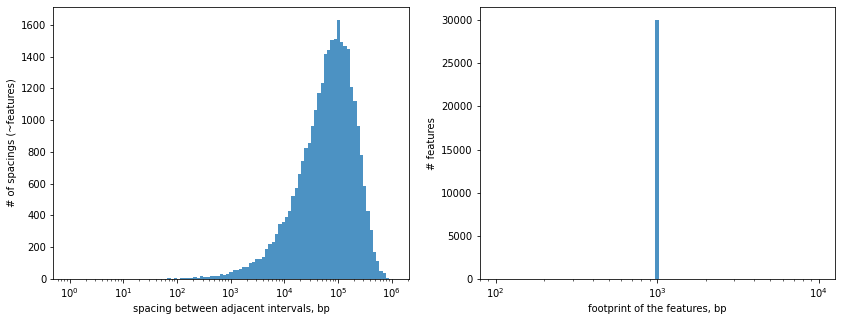

In [31]:
# calculate "spacing" between adjacent intervals:
spcs = []
for chrom, chr_df in df.groupby("chrom"):
    # assuming coordinates are sorted ...
    chrom_spc = chr_df["start"].values[1:] - chr_df["start"].values[:-1]
    spcs.append(chrom_spc)
spcs = np.concatenate(spcs)

# calculate footprints of the features ...
footprints = (df["end"] - df["start"]).values

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

bins = np.geomspace(1,spcs.max(),num=100)
ax1.hist(spcs,bins=bins,log=False,alpha=0.8)#,color="navy")
ax1.set_xscale("log")
ax1.set_xlabel("spacing between adjacent intervals, bp")
ax1.set_ylabel("# of spacings (~features)")

# bins = np.geomspace(footprints.min()-1,footprints.max()+1,num=100)
bins = np.geomspace(100,10_000,num=100)
ax2.hist(footprints,bins=bins,log=False,alpha=0.8)#,color="darkgreen")
ax2.set_xscale("log")
ax2.set_xlabel("footprint of the features, bp")
ax2.set_ylabel("# features")

In [32]:
# now let's compare bioframe clustering/merging, and see what can it do:
clust_radii = np.geomspace(100,150_000,num=50)

# merge with min_dist>0 adjusted
lengths_merge1 = [
    len( bioframe.merge(df, min_dist=pad) ) for pad in clust_radii
]
# now try expand and then merge with min_dist=0
lengths_merge2 = []
for pad in clust_radii:
    _df_exp = df.copy()
    _df_exp = bioframe.expand(
        _df_exp,
        pad=pad/2, # expansion both ways
        side='both',
        limits=sortedchromsizes.to_dict()
    )
    _num_merged_intervals = len( bioframe.merge(_df_exp, min_dist=0) )
    lengths_merge2.append( _num_merged_intervals )

Text(0, 0.5, '# of features after merging')

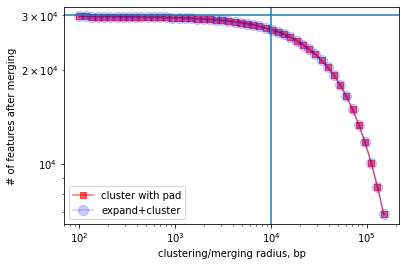

In [41]:
plt.loglog(clust_radii,lengths_merge1,'rs-',label="cluster with pad",alpha=0.6)
plt.loglog(clust_radii,lengths_merge1,'bo-',label="expand+cluster",markersize=10,alpha=0.2)
ax = plt.gca()
ax.legend()
ax.axhline(len(df))
ax.axvline(10_000) # ,label="10kb clustering")
ax.set_xlabel("clustering/merging radius, bp")
ax.set_ylabel("# of features after merging")